# Plot data by segment generation and order number
The following example produces plots similar to those in Bauer et al. 2019: "lapdMouse: Associating lung anatomy with local particle deposition in mice", that present airway segment generation dependent measurements averaged by mouse strain or particle size.

The example below additionally produces plots that show the measurements in dependence of the airway segments' order number following the order definition of Wallau et al. (2000): "Lung morphology in rodents (Mammalia, Rodentia) and its implications for systematics".

In [1]:
import os, glob, pandas, matplotlib, numpy
import matplotlib.pyplot as plt

First, we download the necessary data from the `lapdMouse` data archive using the `lapdMouseUtils` module which is part of the [lapdMousePythonExamples](https://github.com/lapdMouse/lapdMousePythonExamples).

In [2]:
datasetIds = ['m%02d'%i for i in range(1,35)]
from lapdMouseUtils import DBUtil
db=DBUtil()
for i in datasetIds:
    db.downloadFile('%s/%s_Info.md'%(i,i))
    db.downloadFile('%s/%s_AirwayTreeTable.csv'%(i,i))
    db.downloadFile('%s/%s_AirwaySegmentsDeposition.csv'%(i,i))

We read the ``*_Info.md`` files and create a database table ``db`` holding all the mice's meta-data.

In [3]:
def getInfo(infoFilename):
    info = {}
    StringValues = ['Gender', 'Strain', 'Vendor']#, 'Physical abnormalities']
    FloatValues = ['Particle size', 'Exposure time', 'Relative exposure estimate',\
        'Total centerline length', 'Number of branches' ' Number of terminal branches',\
        'Maximum generation number', 'Number of outlet areas', 'Weight (g)', 'Lung volume']
    keys = StringValues
    keys.extend(FloatValues)
    for line in open(infoFilename,'r').read().split('\n'):
        for key in keys:
            if line.find(key+': ')!=-1:
                data = line[line.find(key+': ')+len(key)+2:]
                if key in FloatValues:
                    try:
                        data = float(data.split(' ')[0])
                    except ValueError:
                        data = float('nan')
                info[key] = data
    if 'Strain' in info: info['Strain'] = info['Strain'].upper()
    return info
dbInfo = {i:getInfo('%s/%s_Info.md'%(i,i)) for i in datasetIds}
db = pandas.DataFrame.from_dict(dbInfo, orient='index')

We read the airway tree segment's information ``*_AirwayTreeTable.csv``, add the deposition data from ``*_AirwaySegmentsDeposition.csv``, and calculate generation number the order numbers for each segment.

In [4]:
def getTreeData(structureFile, depositionFile):
    df1 = pandas.read_csv(structureFile, index_col='label')
    df2 = pandas.read_csv(depositionFile, index_col='label', usecols=['label','area','mean','sigma','median','min','max'])
    df = pandas.concat([df1,df2], axis=1)
    df['deposition'] = df['area']*df['mean'].fillna(0.0)
    
    def getGenerationNumber(df):
        generation = pandas.Series(0,index=df.index)
        for index in df.index:
            parentId = df.loc[index,'parent']
            generation[index] = generation[parentId]+1 if parentId!=0 else 1 # trachea (parentId=0) is generation 1
        return generation
    df['generation'] = getGenerationNumber(df)
    
    def getOrderNumber(df):
        order = pandas.Series(0,index=df.index)
        for index in df.index:
            if index==1: continue # don't process the trachea
            currentSegmentOrder = order[index]
            children = df[df['parent']==index]
            radiusThreshold = 0.9*children['radius'].max()
            symmetric = children['radius'].min()>radiusThreshold
            for c in children.index:
                childRadius = children.loc[c,'radius']
                if symmetric: childSegmentOrder = currentSegmentOrder+1
                elif children.loc[c,'radius']<radiusThreshold: childSegmentOrder = currentSegmentOrder+1
                else: childSegmentOrder = currentSegmentOrder
                order[c] = childSegmentOrder
        order[1] = numpy.nan # trachea has no order number
        return order
    df['order'] = getOrderNumber(df)
    
    return df

dbTrees = {i:getTreeData('%s/%s_AirwayTreeTable.csv'%(i,i),'%s/%s_AirwaySegmentsDeposition.csv'%(i,i)) for i in datasetIds}

Then, we create summary statistics for each hierarchy level per dataset

In [5]:
def summarizeTreeData(df, by):
    summary = pandas.DataFrame(index=df[by].dropna().unique())
    summary['Count'] = df.groupby(by).size()
    summary['Radius'] = df.groupby(by)['radius'].mean()
    summary['Segment fraction'] = summary['Count']/summary['Count'].sum()
    # for surface and deposition fraction, we exclude the trachea (index=1)
    df = df.drop(1)
    totalSurface = df['area'].sum()
    summary['Surface fraction'] = df.groupby(by)['area'].sum()/totalSurface
    totalDeposition = df['deposition'].sum()
    summary['Deposition fraction'] = df.groupby(by)['deposition'].sum()/totalDeposition    
    return summary

# summarize by generation number
dbTreeStatsByGeneration = pandas.concat({i:summarizeTreeData(v,'generation') for i,v in dbTrees.items()})
dbTreeStatsByGeneration.index.names = ['ID','level']

# summarize by order number
dbTreeStatsByOrder = pandas.concat({i:summarizeTreeData(v,'order') for i,v in dbTrees.items()})
dbTreeStatsByOrder.index.names = ['ID','level']

Define group-wise averaging that we'll apply to either ``Strain`` or ``Particle size``.

In [6]:
def averageDatasets(db,dbTreeStats,what,by):
    groups = db[by].unique()
    df = dbTreeStats.reset_index()
    d = {g:df[df['ID'].isin(db[db[by]==g].index)].groupby('level')[what].mean() for g in groups}
    return d

Define a utility function to plot generation dependent and order dependent data side by side

In [7]:
def plotSideBySide(what,by,name=None,units='-',scale=1.0):
    if not name: name=what
    plt.figure(figsize=[16,5])
    plt.subplot(1,2,1)
    means = averageDatasets(db,dbTreeStatsByGeneration,what,by)
    for k,v in means.items(): plt.plot(v*scale,label=k)
    plt.legend()
    plt.gca().set_xlabel('Generation number (-)')
    plt.gca().set_ylabel('Average '+name+' ('+units+')');
    plt.gca().set_title('Average  '+name+' by Generation number for each '+by)
    plt.subplot(1,2,2)
    means = averageDatasets(db,dbTreeStatsByOrder,what,by)
    for k,v in means.items(): plt.plot(v*scale,label=k)
    plt.legend()
    plt.gca().set_xlabel('Order number (-)')
    plt.gca().set_ylabel('Average '+name+' ('+units+')');
    plt.gca().set_title('Average '+name+' by Order number for each '+by)

Now we're ready to plot the data

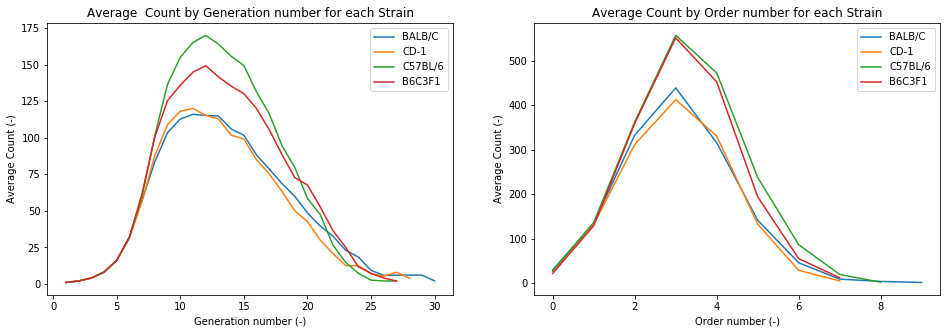

In [8]:
plotSideBySide('Count','Strain')

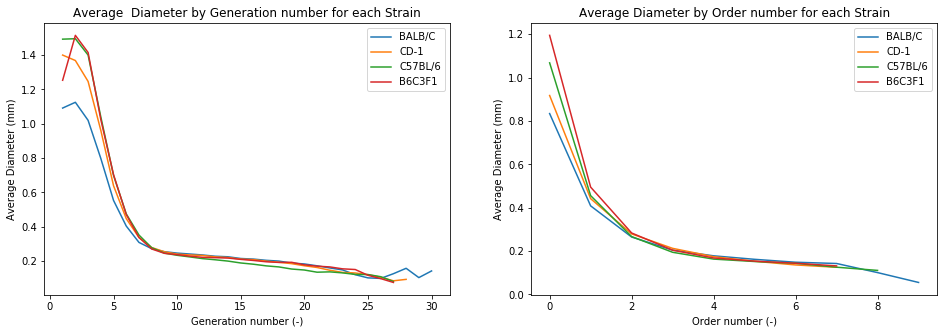

In [9]:
plotSideBySide('Radius','Strain','Diameter','mm',2.0)

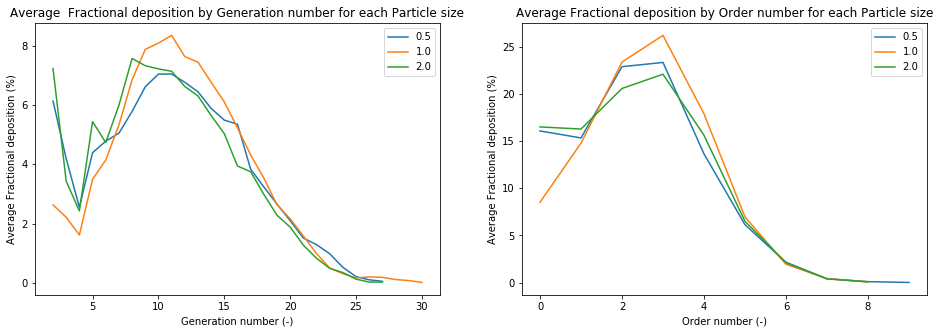

In [10]:
plotSideBySide('Deposition fraction','Particle size','Fractional deposition','%',100.0)

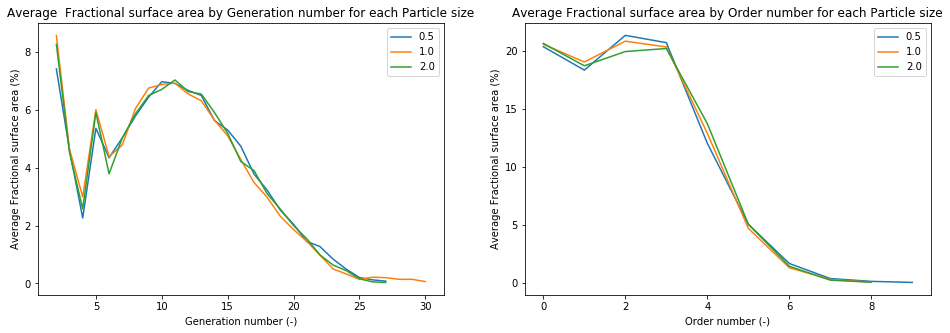

In [11]:
plotSideBySide('Surface fraction','Particle size','Fractional surface area','%',100.0)

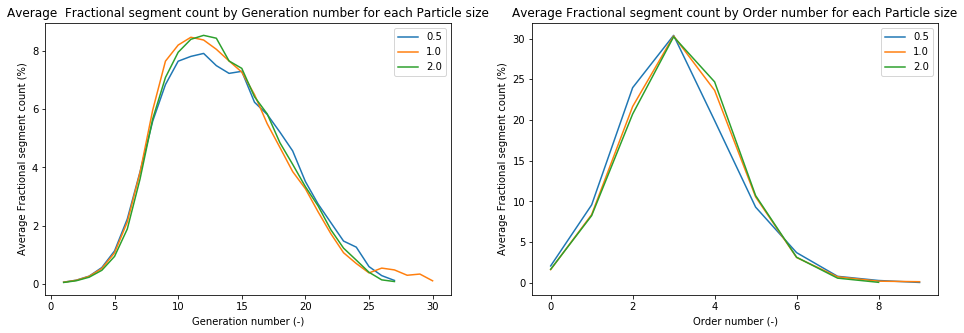

In [12]:
plotSideBySide('Segment fraction','Particle size','Fractional segment count','%',100.0)